In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json

# Read MoCap data and RoboRIO data form files

In [5]:
data_dir = "../../recorded_sensor_data/mocap_12_10-03-30-00/"
sensor_file = data_dir + "sensor_data.csv"
mocap_file = data_dir + "mocap_data.csv"
extra_points_file = data_dir + "extra_points.json"
sensor_reader = csv.reader(open(sensor_file, 'r'))
extra_points = json.load(open(extra_points_file, 'r'))
mocap_reader = csv.reader(open(mocap_file, 'r'))

# read offset to center of robot
marker = extra_points['marker']
robot_center_offset = marker - centroid

# skip headers
next(sensor_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)

sensor_data = []
for sensor_row in sensor_reader:
    data = [float(d) for d in sensor_row]
    if len(data) > 0 and data[-1] > 1800: # hack to skip first round of data
        sensor_data.append(data)
sensor_data = np.array(sensor_data)

mocap_data = []
for mocap_row in mocap_reader:
    data = [float(d) for d in mocap_row]
    if len(data) > 0:
        mocap_data.append(data)
mocap_data = np.array(mocap_data)

[{'name': 'a', 'y': -362.8, 'x': 448.1, 'z': 117.7}, {'name': 'b', 'y': -199.5, 'x': 565.6, 'z': 287.1}, {'name': 'c', 'y': 489.468, 'x': 1431.5, 'z': 409.452}, {'name': 'd', 'y': 124.04, 'x': 1442.2, 'z': 194.53}, {'name': 'e', 'y': -233.25, 'x': 1446.49, 'z': 416.57}]


NameError: name 'marker' is not defined

In [7]:
def yawdiff(y1, y2):
    diff = y2 - y1
    if diff > np.pi:
        return diff - np.pi * 2;
    if diff < -np.pi:
        return diff + np.pi * 2;
    return diff;

### Check the amount of data between the two matches?

In [8]:
print("Seconds of IMU data recorded: ", sensor_data[-1][-1] - sensor_data[0][-1])
print("Seconds of MoCap recorded:", len(mocap_data) / 100)

Seconds of IMU data recorded:  20.88
Seconds of MoCap recorded: 50.27


# Plot Mocap Data by Axis

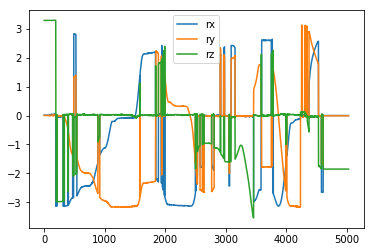

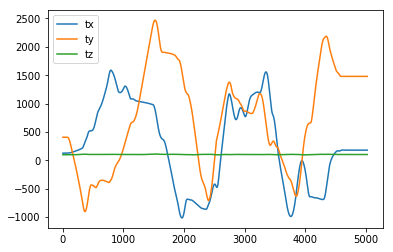

In [9]:
plt.plot(mocap_data[:,2], label="rx")
plt.plot(mocap_data[:,3], label="ry")
plt.plot(mocap_data[:,4], label="rz")
plt.legend()
plt.show()

plt.plot(mocap_data[:,5], label="tx")
plt.plot(mocap_data[:,6], label="ty")
plt.plot(mocap_data[:,7], label="tz")
plt.legend()
plt.show()

# Plot X/Y position from MoCap

In [10]:
mocap_states = np.ndarray((mocap_data.shape[0], 9))
mocap_state = np.zeros(9)
for mocap_idx in range(1, len(mocap_data)):
    data = mocap_data[mocap_idx]
    last_data = mocap_data[mocap_idx - 1]
    rx = data[2]
    ry = data[3]
    rz = data[4]
    tx = data[5] + robot_center_offset[0]
    ty = data[6] + robot_center_offset[1]
    tz = data[7] + robot_center_offset[2]
    mocap_state[0] = tx
    mocap_state[1] = ty
    drz = yawdiff(rz, last_data[4]) # handles wrap-around
    mocap_state[2] += drz
    mocap_states[mocap_idx-1] = mocap_state

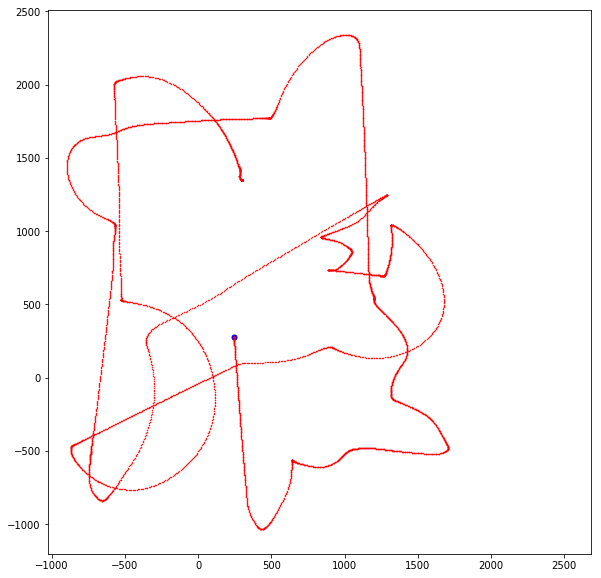

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(mocap_states[0,0], mocap_states[0,1], marker='.', s=100, color='b')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r')
plt.axis("square")
plt.show()

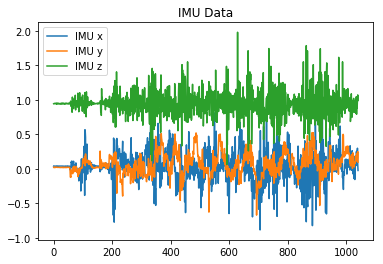

In [12]:
plt.plot(sensor_data[:,0], label="IMU x")
plt.plot(sensor_data[:,1], label="IMU y")
plt.plot(sensor_data[:,2], label="IMU z")
plt.title("IMU Data")
plt.legend()
plt.show()

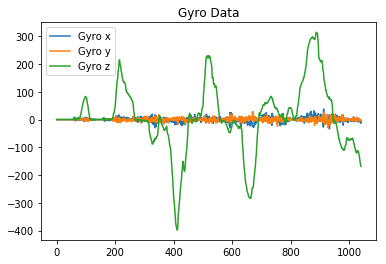

In [13]:
plt.plot(sensor_data[:,3], label="Gyro x")
plt.plot(sensor_data[:,4], label="Gyro y")
plt.plot(sensor_data[:,5], label="Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.show()

In [14]:
means = np.mean(sensor_data,axis=0)
print("Average Accel X value:", means[0])
print("Average Accel Y value:", means[1])
print("Average Accel Z value:", means[2])

Average Accel X value: 0.0352497946718
Average Accel Y value: 0.0665275560355
Average Accel Z value: 0.944759155566


In [15]:
yaws = []
yaw = 0
last_t = sensor_data[0][-1]
for data in sensor_data:
    gyro_z = data[5]
    dt_s = data[-1] - last_t
    yaw += dt_s * gyro_z
    yaws.append(yaw)
    last_t = data[-1]

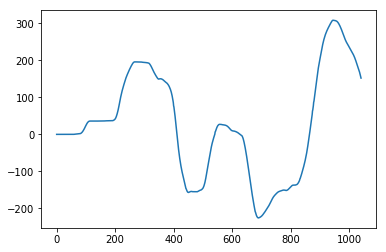

In [16]:
plt.plot(yaws, label="integrated gyro")
plt.show()

## Double Integrating Accelerometer

In [99]:
def DoubleIntegrateAccelerometer(accelerometer_data, K, T, b):
    x = 0
    y = 0
    vx = 0
    vy = 0
    dt_s = .02
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    
    for data in accelerometer_data:
        a_s = data[3:6]
        a_o = T@K@(a_s+b).T
        ax = a_o[0][0]
        ay = a_o[1][0]
        
#         print(a_o, a_s, dt_s)
        vx += ax * dt_s
        vy += ay * dt_s
        x += vx * dt_s + 0.5 * ax * dt_s ** 2
        y += vy * dt_s + 0.5 * ay * dt_s ** 2
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

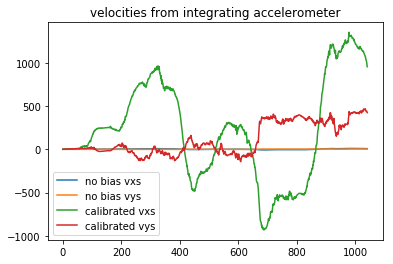

In [136]:
K = np.array([[1,0,0],[0,1,0],[0,0,1]])*100
T = np.array([[1,0,0.01],[0,1,0],[0,0,1]])
b = np.array([[0.0385,0.041,0]])
no_bias = DoubleIntegrateAccelerometer(sensor_data, np.eye(3), np.eye(3), np.array([[0,0,0]]))
calib = DoubleIntegrateAccelerometer(sensor_data, K, T, b)
plt.plot(no_bias[2], label="no bias vxs")
plt.plot(no_bias[3], label="no bias vys")
plt.plot(calib[2], label="calibrated vxs")
plt.plot(calib[3], label="calibrated vys")
plt.title("velocities from integrating accelerometer")
plt.legend()
plt.show()

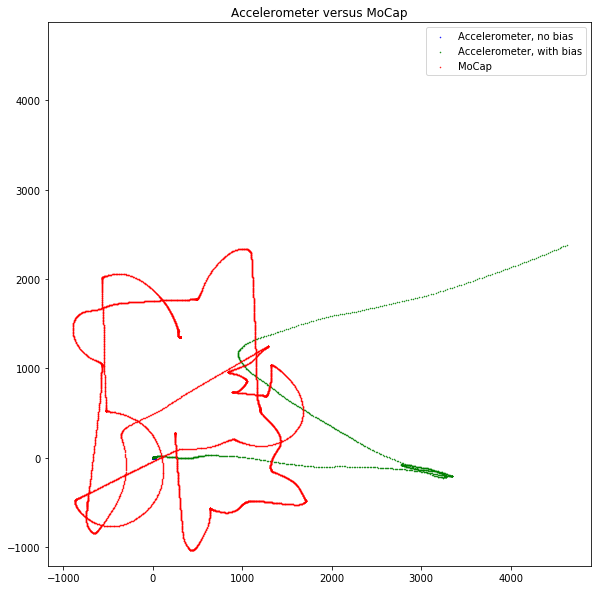

In [137]:
plt.figure(figsize=(10,10))
plt.scatter(no_bias[0], no_bias[1], marker='.', s=1, color='b', label='Accelerometer, no bias')
plt.scatter(calib[0], calib[1], marker='.', s=1, color='g', label='Accelerometer, with bias')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r', label='MoCap')
plt.axis("square")
plt.title("Accelerometer versus MoCap")
plt.legend()
plt.show()

## Testing on Turtlebot accelerometer data

Average Accel X value: -0.00999664059554
Average Accel Y value: 0.00540464022406


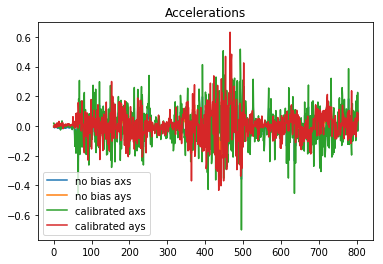

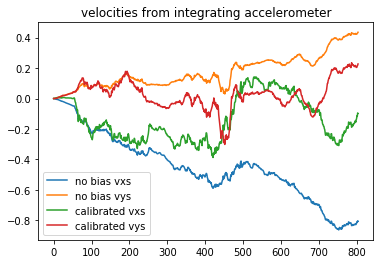

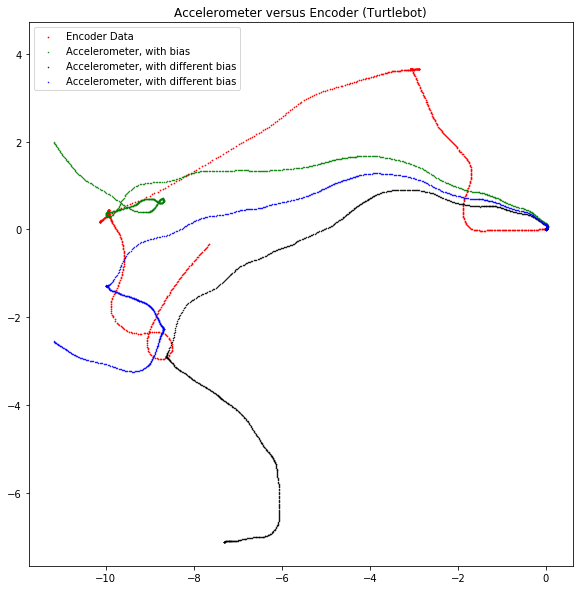

In [20]:
turtlebot_dir = "../../recorded_sensor_data/turtlebot_original/"
data_file = turtlebot_dir + "interpolated_data.csv"
reader = csv.reader(open(data_file, 'r'))

accelerometer_data = []
encoder_x = 0
encoder_y = 0
encoder_theta = 0
encoder_xs = []
encoder_ys = []
alpha = 1.0
wheel_radius_m = 0.038
track_width_m = 0.23
dt_s = 0.1

next(reader)
for data in reader:
    wl = float(data[0])
    wr = float(data[1])
    ax = float(data[2])
    ay = float(data[3])
    t = float(data[-1])
    
    accelerometer_data.append([ax, ay, t])
    B = alpha * track_width_m
    T = wheel_radius_m / B * np.array([[B / 2.0, B / 2.0], [-1, 1]])
    dydt, dpdt = T @ np.array([wl, wr])
    encoder_x = encoder_x + np.cos(encoder_theta) * dydt * dt_s
    encoder_y = encoder_y + np.sin(encoder_theta) * dydt * dt_s
    encoder_theta += dpdt * dt_s
    
    encoder_xs.append(encoder_x)
    encoder_ys.append(encoder_y)

means = np.mean(accelerometer_data,axis=0)
print("Average Accel X value:", means[0])
print("Average Accel Y value:", means[1])

no_bias = DoubleIntegrateAccelerometer(accelerometer_data, x_bias=0, y_bias=0, x_scale=1, y_scale=1)
calib = DoubleIntegrateAccelerometer(accelerometer_data, x_bias=-0.0094, y_bias=0.004, x_scale=2, y_scale=2)
calib2 = DoubleIntegrateAccelerometer(accelerometer_data, x_bias=means[0], y_bias=means[1], x_scale=2, y_scale=2)
calib3 = DoubleIntegrateAccelerometer(accelerometer_data, x_bias=-0.0094, y_bias=0.0047, x_scale=2, y_scale=2)

plt.plot(no_bias[4], label="no bias axs")
plt.plot(no_bias[5], label="no bias ays")
plt.plot(calib[4], label="calibrated axs")
plt.plot(calib[5], label="calibrated ays")
plt.title("Accelerations")
plt.legend()
plt.show()

plt.plot(no_bias[2], label="no bias vxs")
plt.plot(no_bias[3], label="no bias vys")
plt.plot(calib[2], label="calibrated vxs")
plt.plot(calib[3], label="calibrated vys")
plt.title("velocities from integrating accelerometer")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(encoder_xs, encoder_ys, marker='.', s=2, color='r', label='Encoder Data')
# plt.scatter(no_bias[0], no_bias[1], marker='.', s=1, color='b', label='Accelerometer, no bias')
plt.scatter(calib[0], calib[1], marker='.', s=1, color='g', label='Accelerometer, with bias')
plt.scatter(calib2[0], calib2[1], marker='.', s=1, color='k', label='Accelerometer, with different bias')
plt.scatter(calib3[0], calib3[1], marker='.', s=1, color='b', label='Accelerometer, with different bias')
plt.title("Accelerometer versus Encoder (Turtlebot)")
plt.axis("square")
plt.legend()
plt.show()

# Camera Stuff

In [ ]:
import cv2

In [ ]:
img_dir = "../../recorded_sensor_data/practice_image_processing/"
vid_file = img_dir + "out.avi"
vid = cv2.VideoCapture(vid_file)
img_timestamp_file = img_dir + "frame_time_stamps.csv"
img_timestamp_reader = csv.reader(open(img_timestamp_file))
camera_xs = []
camera_ys = []
for timestamp in img_timestamp_reader:
    t = float(timestamp[0])
    ok, frame = vid.read()
    
    # (t, frame)
    # detect markers in frame
    
    # compute position relative to markers
    camera_x = 0
    camera_y = 0
    
    camera_xs.append(camera_x)
    camera_ys.append(camera_y)
    
    if not ok:
        break

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(camera_xs, camera_ys, marker='.', s=1, color='b', label='camera')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r', label='MoCap')
plt.title("Accelerometer versus MoCap")
plt.legend()
plt.show()